In [1]:
from brian2 import *
from util.visualization_functions import *
from util.analysis_functions import *
%matplotlib inline
#set_device('cpp_standalone') # for C++ speedup


In [2]:
# trying to recreate the simulation used in Ocker 2015

start_scope()

# model parameters
gL = .1 * msiemens * cm**-2 # leak conductance
vL = -72 * mV               # leak reversal potential
C = 1 * ufarad * cm**-2     # membrane capacitance
delta = 1.4 * mV            # action potential steepness
vT = -48 * mV               # action potential initiation threshold
mu = 1 * uamp * cm**-2      # noise mean
sigma = 9 * mV              # noise std dev

# other cell params
vTh = 30 * mV               # spike threshold
vR = -72 * mV               # reset potential
tRef = 2 * ms               # action potential width (refractory time)

# network params
p = 0.15                    # connection density
N = 1000                     # number of neurons

# stdp params
wMax = 5 / N / p * uamp * cm**-2    # max syn weight - TODO: generate wMax from connectivity stats like in paper?
tauPre = 5 * ms #15 * ms            # synaptic time constant
tauPost = 5 * ms #2 * tauPre        # synaptic time constant
dApost = -wMax / 5 / N              # f neg (f post)
dApre = -dApost * tauPost / tauPre  # f pos (f pre)

# simulation params
sim_time_ms = 5000                  # simulation time in ms
monitor_dt_ms = sim_time_ms / 100   # timestep for monitor evaluation

# model
dynamics = '''
dv/dt = (gL * (vL - v) + gL * delta * exp((v - vT) / delta) + (mu + gL * sigma * sqrt(2 * C / gL) * xi)) / C : volt (unless refractory)
'''

G = NeuronGroup(N, dynamics, 
                threshold='v > vTh',
                reset='v = vR',
                refractory='tRef',
                method='euler')

synapses = Synapses(G, G,
             '''w : amp * meter**-2
                dApre/dt = -Apre / tauPre : amp * meter**-2 (event-driven)
                dApost/dt = -Apost / tauPost : amp * meter**-2 (event-driven)''',
             on_pre='''v += w * v * cm**2 * amp**-1
                    Apre += dApre
                    w = clip(w + Apost, 0, wMax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, wMax)'''
            )
           
# TODO: initialize mean weight over some distribution?
synapses.connect(condition='i!=j', p=p)
synapses.w = 'wMax * rand() / 3'

# monitors
#v_mon = StateMonitor(G, 'v', record=True)
#sp_mon_exc = SpikeMonitor(G)
w_mon = StateMonitor(synapses, 'w', record=True, dt=monitor_dt_ms * ms)

# initial value
#G.v = 5 * mV 

# initial stats
#(p0, q_div0, q_con0, q_ch0, q_rec0) = compute_motif_stats(G, synapses)

# run
run(sim_time_ms * ms, report='text')

# final stats
#(p, q_div, q_con, q_ch, q_rec) = compute_motif_stats(G, synapses)

# plots
#plot_v(v_mon, sp_mon_exc, 0, True)
#plot_spike_trains(sp_mon_exc)


#print("p: " + str(p0) + "-->" + str(p))
#print("q_div: " + str(q_div0) + "-->" + str(q_div))
#print("q_con: " + str(q_con0) + "-->" + str(q_con))
#print("q_ch: " + str(q_ch0) + "-->" + str(q_ch))
#print("q_rec: " + str(q_rec0) + "-->" + str(q_rec))





WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 8 lines of abstract code, first line is: "_Apost := Apost * exp(_lio_1 * (- (t - lastupdate))) (constant)"
 [brian2.codegen.generators.base]


Starting simulation at t=0. s for a duration of 5. s
5. s (100%) simulated in 6s


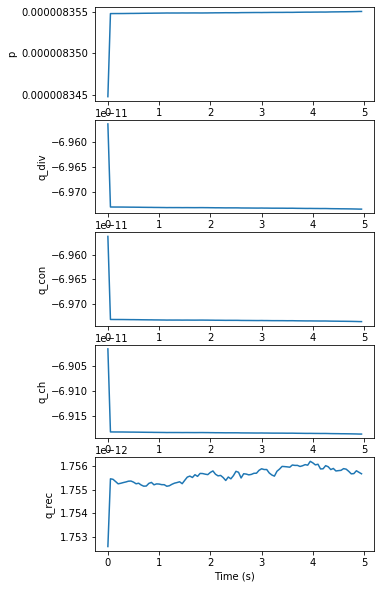

In [3]:
# more plots
#plot_avg_syn_weight(w_mon, wMax)

# figure 7
plot_motif_dynamics(w_mon, synapses, N)